In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [146]:
df = pd.read_csv('Final Data');
po = df['Power Outage'];
df = df.drop(['Power Outage'], axis = 1);
X_train, X_test, y_train, y_test = train_test_split(df, po, test_size=0.33, random_state = 1234);
df.head()

,PRCP,Delta T Min,Delta T Max,TMAX,5 second wind speed squared,2 min wind speed squared,Avg Wind Speed Squared,Fog/Ice,Heavy/Freezing Fog,Thunder,Smoke/Haze
0,0.000,0.000000,0.000000,0.471698,0.005809,0.014808,0.036815,0.0,0.0,0.0,0.0
1,0.000,0.000054,0.000886,0.487421,0.019600,0.057484,0.154984,0.0,0.0,0.0,0.0
2,0.000,0.001362,0.000016,0.473795,0.011571,0.037627,0.104491,0.0,0.0,0.0,0.0
3,0.005,0.012255,0.000319,0.481132,0.003535,0.009524,0.019968,1.0,0.0,0.0,0.0
4,0.000,0.002301,0.000016,0.473795,0.012885,0.041951,0.049338,0.0,0.0,0.0,0.0


In [147]:
#Undersample the number of zeroes
import pandas_ml as pdml
df_ML = pdml.ModelFrame(X_train, target = y_train)
print("Before sampling ratio");
print(df_ML.target.value_counts());
sampler = df_ML.imbalance.under_sampling.RandomUnderSampler(ratio=0.1);
df_ML = df_ML.fit_sample(sampler);
print("Final counts after undersampling the zeroes");
print(df_ML.target.value_counts());
X_train = df_ML.iloc[:,1:];
y_train = df_ML['Power Outage'];
df_ML.head()

Before sampling ratio
0.0    1838
1.0     111
Name: Power Outage, dtype: int64
Final counts after undersampling the zeroes
0.0    1110
1.0     111
Name: Power Outage, dtype: int64


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


,Power Outage,PRCP,Delta T Min,Delta T Max,TMAX,5 second wind speed squared,2 min wind speed squared,Avg Wind Speed Squared,Fog/Ice,Heavy/Freezing Fog,Thunder,Smoke/Haze
0,0.0,0.0000,0.375213,0.513042,0.850105,0.012885,0.037627,0.069040,0.0,0.0,0.0,0.0
1,0.0,0.0575,0.286284,0.888231,0.969602,0.018408,0.057484,0.180098,1.0,0.0,0.0,0.0
2,0.0,0.0000,0.000667,0.471293,0.834382,0.008444,0.028859,0.085850,0.0,0.0,0.0,0.0
3,0.0,0.0000,0.263082,0.335664,0.165618,0.012885,0.037627,0.147262,0.0,0.0,0.0,1.0
4,0.0,0.0000,0.001362,0.109792,0.646751,0.019600,0.057484,0.206686,0.0,0.0,0.0,0.0


In [148]:
#Oversampling the number of ones
from imblearn.over_sampling import SMOTE
sampler = SMOTE(random_state=44, ratio=1);
X_train, y_train = sampler.fit_sample(X_train, y_train);

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


0.8202702702702702
Best parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'n_estimators': 150}
Accuracy:  0.786680541103
[ 0.10979702  0.15439261  0.16209521  0.11738638  0.09768559  0.13608857
  0.12376716  0.00872819  0.0306622   0.02639071  0.03300635]


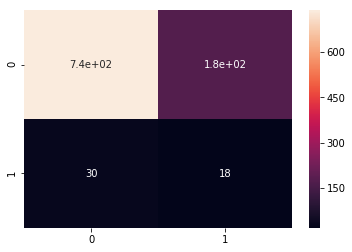

               precision    recall  f1-score   support

  Normal Days       0.96      0.81      0.88       913
Power Outages       0.09      0.38      0.15        48

  avg / total       0.92      0.79      0.84       961



In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 75 ,100, 150]
             }


DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced", max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')

grid_search_ABC.fit(X_train, y_train);
print(grid_search_ABC.best_score_);
print('Best parameters: {}'.format(grid_search_ABC.best_params_));
clf = grid_search_ABC.best_estimator_;


clf.fit(X_train, y_train);
scores = cross_val_score(clf, X_train, y_train);
pred = clf.predict(X_test);


accuracy = accuracy_score(y_test, pred);
print("Accuracy: ", accuracy);
print(clf.feature_importances_)
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, pred));

sns.heatmap(cm, annot=True);

plt.show();
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, target_names = ['Normal Days', 'Power Outages']));


Accuracy:  0.779396462019


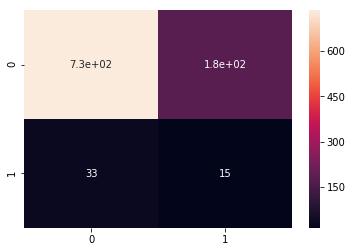

In [150]:
arr = list(y_train > 0);
test = [];
for i in arr:
    if (i==False):
        test.append(1);
    else:
        test.append(20);
        
clf.fit(X_train, y_train, sample_weight = test);
pred = clf.predict(X_test);


accuracy = accuracy_score(y_test, pred);

print("Accuracy: ", accuracy);
#print(clf.feature_importances_)
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, pred));

sns.heatmap(cm, annot=True);

plt.show();

In [151]:
clf = GradientBoostingClassifier(n_estimators = 200, learning_rate=1.0, max_depth=1, random_state=123).fit(X_train, y_train);

pred = clf.predict(X_test);
print(clf.score(X_test, y_test));

0.798126951093


In [152]:
accuracy = accuracy_score(y_test, pred);

print("Accuracy: ", accuracy);
print(clf.feature_importances_)

Accuracy:  0.798126951093
[ 0.07   0.065  0.06   0.1    0.085  0.54   0.055  0.005  0.015  0.     0.005]


Accuracy:  0.798126951093


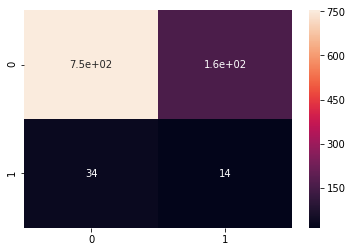

In [153]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, pred));

sns.heatmap(cm, annot=True);
print("Accuracy: ", accuracy);
plt.show();

In [154]:
#Voting classifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import product

In [ ]:
clf2 = KNeighborsClassifier(n_neighbors=5)
clf4 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=12345)
clf5 = GradientBoostingClassifier(n_estimators = 200, learning_rate=1, max_depth=1, random_state=123)

eclf = VotingClassifier(estimators=[ ('knn', clf2),('rforest', clf4), ('gboost', clf5)], voting = 'hard');



In [ ]:
print("Accuracy for cross validation run: ");
for clf, label in zip([clf2, clf4, clf5, eclf], ['K Nearest Neighbors', 'Random Forest', 'Gradient Boost', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), label));
eclf = eclf.fit(X_train, y_train);from sklearn.metrics import confusion_matrix
pred = eclf.predict(X_test);
cm = pd.DataFrame(confusion_matrix(y_test, pred));
print("Accuracy for test data");
sns.heatmap(cm, annot=True);
print("Accuracy: ", accuracy);
plt.show();

Accuracy for cross validation run: 
Accuracy: 0.83 (+/- 0.01) [K Nearest Neighbors]
